
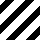
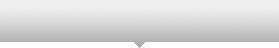
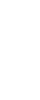
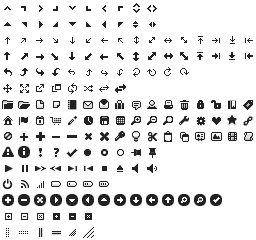
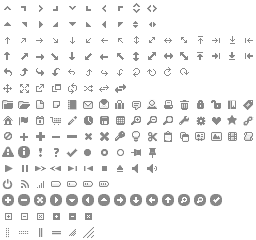
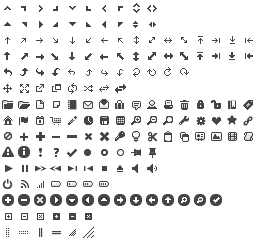
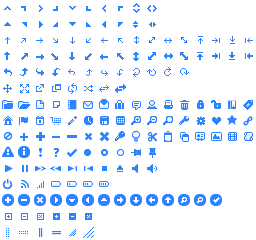
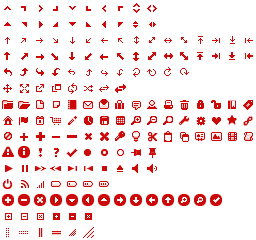
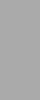
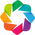
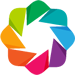
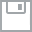
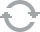
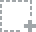
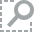
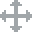
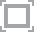
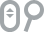

In [338]:
%matplotlib inline
# data manipulation and modeling
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas.stats.moments import ewma, ewmcorr

# graphix
import matplotlib.pyplot as plt
import prettyplotlib as pplt
import seaborn as sns
import statsmodels.graphics.tsaplots as tsaplots

from bokeh.plotting import figure,gridplot,show,output_notebook
from bokeh.models import Range1d
output_notebook()

# utility
import os

# notebook parameters
pd.set_option('display.max_columns', 40) # number of columns in training set
plt.rcParams['figure.figsize'] = (25.0, 25.0)

In [2]:
training_data = pd.read_csv("TrainingSet.csv", index_col=0)
submission_labels = pd.read_csv("SubmissionRows.csv", index_col=0)

In [3]:
training_data.head(100)

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],1986 [YR1986],1987 [YR1987],1988 [YR1988],1989 [YR1989],1990 [YR1990],1991 [YR1991],1992 [YR1992],1993 [YR1993],1994 [YR1994],1995 [YR1995],1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.769214e+00,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.027746e+00,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.244887e+00,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.293310e+01,Afghanistan,allsi.gen_pop,(%) Generosity of All Social Insurance
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.899681e+01,Afghanistan,allsp.gen_pop,(%) Generosity of All Social Protection
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.242306e+01,Afghanistan,allsa.gen_pop,(%) Generosity of All Social Safety Nets
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.205600e-01,Afghanistan,allsi.cov_pop,(%) Program participation - All Social Insurance
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.496313e+01,Afghanistan,allsp.cov_pop,(%) Program participation - All Social Protection
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.451376e+01,Afghanistan,allsa.cov_pop,(%) Program participation - All Social Safety ...
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,Afghanistan,lm_ub.cov_pop,(%) Program participation - Unemp benefits and...


In [4]:
submission_labels.head()

,2008 [YR2008],2012 [YR2012]
559,NaN,NaN
618,NaN,NaN
753,NaN,NaN
1030,NaN,NaN
1896,NaN,NaN


Submission labels are simpler. First observation is we want to predict 2008 and 2012 (and not the years in between). Second observation is that the index values indentify specific rows in the training set. E.g., we want to predict the row in the training set that has the ID 559. Just to look that up:

In [5]:
training_data.loc[559]

1972 [YR1972]                                    NaN
1973 [YR1973]                                    NaN
1974 [YR1974]                                    NaN
1975 [YR1975]                                    NaN
1976 [YR1976]                                    NaN
1977 [YR1977]                                    NaN
1978 [YR1978]                                    NaN
1979 [YR1979]                                    NaN
1980 [YR1980]                                    NaN
1981 [YR1981]                                    NaN
1982 [YR1982]                                    NaN
1983 [YR1983]                                    NaN
1984 [YR1984]                                    NaN
1985 [YR1985]                                    NaN
1986 [YR1986]                                    NaN
1987 [YR1987]                                    NaN
1988 [YR1988]                                    NaN
1989 [YR1989]                                    NaN
1990 [YR1990]                                 

make it easier to grab any column that we want.

In [5]:
def generate_year_list(start, stop=None):
    """ 
    make a list of column names for specific years
    in the format they appear in the data frame start/stop inclusive
    """

    if isinstance(start, list):
        data_range = start
    elif stop:
        data_range = range(start, stop+1)
    else:
        data_range = [start]
    
    yrs = []
    
    for yr in data_range:
        yrs.append("{0} [YR{0}]".format(yr))
        
    return yrs

# ========== TEST CASES =======
# one year
print generate_year_list(2008)

# start and stop (inclusive)
print generate_year_list(1985, 1990)

# custom year list
print generate_year_list([1985, 1990])

['2008 [YR2008]']
['1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]', '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]']
['1985 [YR1985]', '1990 [YR1990]']


In [62]:
prediction_rows = training_data.loc[submission_labels.index]

In [64]:
#prediction_rows

In [65]:
prediction_rows = prediction_rows[generate_year_list(1972, 2007)]
prediction_rows

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],1986 [YR1986],1987 [YR1987],1988 [YR1988],1989 [YR1989],1990 [YR1990],1991 [YR1991],1992 [YR1992],1993 [YR1993],1994 [YR1994],1995 [YR1995],1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007]
559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048000,0.049000,0.049000,0.049000,0.049000,0.084000,0.118000,0.152000,0.187000,0.221000,0.256000,0.291000,0.325000,0.360000,0.395000,0.430000,0.465000
618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000047,0.000046,0.000879,0.001058,0.012241,0.021071,0.019000
753,0.296000,0.290900,0.285200,0.279800,0.274200,0.268300,0.262400,0.256500,0.250300,0.243900,0.237400,0.230400,0.222900,0.215100,0.207100,0.199300,0.191400,0.183600,0.176200,0.169300,0.162700,0.157100,0.152100,0.147900,0.144600,0.141700,0.139100,0.136600,0.133900,0.131000,0.127700,0.124400,0.121000,0.117700,0.114500,0.111500
1030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
1896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.964000,0.964000,0.965000,0.965000,0.965000,0.965000,0.965000,0.964000,0.964000,0.963000,0.963000,0.962000,0.962000,0.961000
1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000112,0.000322,0.000486,0.000650,0.000814,0.001141,0.003258,0.003901,0.009719,0.024204,0.060439,0.096100,0.150361
2090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.051600,0.049900,0.048300,0.046800,0.045400,0.043900,0.042500,0.041200,0.039800,0.038400,0.037100,0.035800,0.034400,0.032900,0.031500,0.030000,0.028600,0.027100,0.025700,0.024500,0.023300,0.022200,0.021200,0.020300
2690,NaN,0.676752,0.717112,0.740751,0.758748,0.773166,0.782735,0.782891,0.793252,0.795066,0.790398,0.783163,0.793246,0.796854,0.808138,0.820693,0.828933,0.834781,0.833833,0.844134,0.849658,0.842352,0.841658,0.846157,0.845856,0.844342,NaN,0.878822,0.890507,0.915648,0.932315,0.939567,0.946588,0.946235,0.942501,0.939003
3233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.939000,0.940000,0.941000,0.942000,0.935000,0.928000,0.921000,0.914000,0.908000,0.901000,0.894000,0.887000,0.881000,0.874000,0.866000,0.859000,0.852000,0.844000
3292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000004,0.000018,0.000017,0.000103,0.000202,0.001995,0.004917,0.006461,0.015916,0.021954,0.046345,0.058439,0.073760,0.094512


In [10]:
#prediction_rows.info()

In [12]:
# p1 = figure(title='Title',plot_width=800, plot_height=800)
# p1.line(generate_year_list(2000, 2007),training_data.loc[737],alpha=.4, line_width=4)
# show(p1)
#country, descrip = training_data[["Country Name", "Series Name"]].loc[r]

#p2 = figure(title="{} - {}".format(country, descrip),plot_width=500, plot_height=200,title_text_font_size='6pt')
#p2 = figure(title="Try",plot_width=500, plot_height=200,title_text_font_size='6pt')
#p2.line(generate_year_list(1972, 2007),training_data[100:101,:],alpha=.4, line_width=2)
#p2.scatter(generate_year_list(2000, 2007),training_data.loc[737], alpha=0.4,)
#show(p2)

In [ ]:
np.random.seed(10)
rand_rows = np.random.choice(prediction_rows.index.values, size=10)

def plot_rows(data, ids=None):
#     bmap = pplt.brewer2mpl.get_map('Set3','Qualitative', 10)
#     colors = bmap.mpl_colors
    
    if not None == ids:
        get_rows = lambda: enumerate(ids)
    else:
        get_rows = lambda: enumerate(data.index.values)
    
    for i,r in get_rows():
        time_data = data.loc[r]

        just_years = [y[:4] for y in data.columns]
        X = pd.DatetimeIndex(just_years)
        country, descrip = training_data[["Country Name", "Series Name"]].loc[r]

        p = figure(title="{} - {}".format(country, descrip),plot_width=500, plot_height=200,title_text_font_size='6pt')
        p.line(X, time_data,alpha=.4, line_width=2)
        p.scatter(X, time_data, alpha=0.4,)
        show(p)
plot_rows(prediction_rows, ids=rand_rows)


In [ ]:
# grab a random sample of 10 of the timeseries
np.random.seed(100)
rand_rows = np.random.choice(prediction_rows.index.values, size=1000)

def plot_rows(data, ids=None, linestyle="-", legend=True):
    # get some colors for the lines
    bmap = pplt.brewer2mpl.get_map('Set3','Qualitative', 10, True)
    #colors = bmap.mpl_colors
    
    if not None == ids:
        get_rows = lambda: enumerate(ids)
    else:
        get_rows = lambda: enumerate(data.index.values)
    
    for i, r in get_rows():
        # get the time series values
        time_data = data.loc[r]

        # create an x axis to plot along
        just_years = [y[:4] for y in data.columns]
        X = pd.DatetimeIndex(just_years)

        # get time series info for labeling
        country, descrip = training_data[["Country Name", "Series Name"]].loc[r]

        # plot the series
        plt.plot(X, time_data, 
                 label="{} - {}".format(country, descrip), ls=linestyle)
        plt.scatter(X, time_data, alpha=0.8)

#     if legend:
#         plt.legend(loc=0)
    plt.title("Progress Towards Subset of MDGs")

plot_rows(prediction_rows, ids=rand_rows)
plt.show()

In [10]:
country_data = training_data[training_data["Country Name"] == 'India']
country_values = country_data[generate_year_list(1972, 2007)].values

In [66]:
# country_data

In [64]:
# country_values

In [73]:
#country_data.info()

In [11]:
countrydata = training_data.groupby("Country Name")

In [54]:
india = countrydata.get_group("India")
india

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],1986 [YR1986],1987 [YR1987],1988 [YR1988],1989 [YR1989],1990 [YR1990],1991 [YR1991],1992 [YR1992],1993 [YR1993],1994 [YR1994],1995 [YR1995],1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
114990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.072211e+01,NaN,NaN,India,allsi.cov_pop,(%) Program participation - All Social Insurance
114991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.998927e+01,NaN,NaN,India,allsp.cov_pop,(%) Program participation - All Social Protection
114992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.840343e+01,NaN,NaN,India,allsa.cov_pop,(%) Program participation - All Social Safety ...
114993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.995493e+00,NaN,NaN,India,lm_ub.cov_pop,(%) Program participation - Unemp benefits and...
114994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.466854e+01,NaN,NaN,India,PA.NUS.PPP.05,"2005 PPP conversion factor, GDP (LCU per inter..."
114995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.560154e+01,NaN,NaN,India,PA.NUS.PRVT.PP.05,"2005 PPP conversion factor, private consumptio..."
114996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.860000e+01,NaN,NaN,NaN,NaN,NaN,6.660000e+01,NaN,NaN,NaN,NaN,NaN,NaN,6.900000e+01,NaN,India,SH.STA.ARIC.ZS,ARI treatment (% of children under 5 taken to ...
114998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.824938e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.563843e-01,8.571408e-01,8.565256e-01,9.079991e-01,NaN,NaN,NaN,9.909380e-01,India,2.1,Achieve universal primary education
114999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.611141e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.790078e+01,7.875435e+01,7.928618e+01,8.922467e+01,NaN,NaN,NaN,NaN,India,SE.PRM.TENR.FE,"Adjusted net enrollment rate, primary, female ..."
115000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.952264e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.273536e+01,9.207028e+01,9.144681e+01,9.222992e+01,NaN,NaN,NaN,NaN,India,SE.PRM.TENR.MA,"Adjusted net enrollment rate, primary, male (%..."


In [255]:
india_values = india[generate_year_list(1972, 2007)].values
india_values

array([[         nan,          nan,          nan, ...,  10.72211477,
                 nan,          nan],
       [         nan,          nan,          nan, ...,  39.98927274,
                 nan,          nan],
       [         nan,          nan,          nan, ...,  28.40343153,
                 nan,          nan],
       ..., 
       [         nan,          nan,          nan, ...,          nan,
         34.7       ,          nan],
       [         nan,          nan,          nan, ...,          nan,
         14.1       ,          nan],
       [         nan,          nan,          nan, ...,  36.8       ,
         37.2       ,  37.5       ]])

In [116]:
#india[generate_year_list(1972, 2007)]

In [30]:
# i2_notnull = india[india.columns[:36]].fillna(method = 'bfill', axis = 1)
# i2_notnull

In [31]:
# i2_notnull=i2_notnull[i2_notnull.columns[:36]].fillna(method = 'ffill', axis = 1)
# i2_notnull

In [ ]:
# normalized_data = StandardScaler().fit_transform(data.astype(float))

In [212]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [171]:
# figure(figsize = (10,7))
# ts = pd.Series(i3_notnull.loc[115001], index=pd.date_range(start = '1972', end = '2007'))
# ts = ts.cumsum()
# ts.plot()

In [32]:
# india1 = countrydata.get_group("India")

In [34]:
# india1 = india1[india1.columns[:36]].fillna(method = 'bfill', axis = 1)
# india1

In [35]:
# india1 = india1[india1.columns[:36]].fillna(method = 'ffill', axis = 1)
# india1

In [121]:
india2 = countrydata.get_group("India")

In [122]:
india2[india2.columns[:36]] = india2[india2.columns[:36]].fillna(method = 'bfill', axis = 1)
india2

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],1986 [YR1986],1987 [YR1987],1988 [YR1988],1989 [YR1989],1990 [YR1990],1991 [YR1991],1992 [YR1992],1993 [YR1993],1994 [YR1994],1995 [YR1995],1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
114990,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,NaN,NaN,India,allsi.cov_pop,(%) Program participation - All Social Insurance
114991,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,NaN,NaN,India,allsp.cov_pop,(%) Program participation - All Social Protection
114992,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,NaN,NaN,India,allsa.cov_pop,(%) Program participation - All Social Safety ...
114993,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,NaN,NaN,India,lm_ub.cov_pop,(%) Program participation - Unemp benefits and...
114994,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,NaN,NaN,India,PA.NUS.PPP.05,"2005 PPP conversion factor, GDP (LCU per inter..."
114995,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,NaN,NaN,India,PA.NUS.PRVT.PP.05,"2005 PPP conversion factor, private consumptio..."
114996,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e

In [123]:
india2[india2.columns[:36]] = india2[india2.columns[:36]].fillna(method = 'ffill', axis = 1)
india2

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],1986 [YR1986],1987 [YR1987],1988 [YR1988],1989 [YR1989],1990 [YR1990],1991 [YR1991],1992 [YR1992],1993 [YR1993],1994 [YR1994],1995 [YR1995],1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
114990,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,India,allsi.cov_pop,(%) Program participation - All Social Insurance
114991,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,India,allsp.cov_pop,(%) Program participation - All Social Protection
114992,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,India,allsa.cov_pop,(%) Program participation - All Social Safety ...
114993,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,India,lm_ub.cov_pop,(%) Program participation - Unemp benefits and...
114994,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,India,PA.NUS.PPP.05,"2005 PPP conversion factor, GDP (LCU per inter..."
114995,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,India,PA.NUS.PRVT.PP.05,"2005 PPP conversion factor, private consumptio..."
114996,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860

In [124]:
india2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240 entries, 114990 to 116318
Data columns (total 39 columns):
1972 [YR1972]    1240 non-null float64
1973 [YR1973]    1240 non-null float64
1974 [YR1974]    1240 non-null float64
1975 [YR1975]    1240 non-null float64
1976 [YR1976]    1240 non-null float64
1977 [YR1977]    1240 non-null float64
1978 [YR1978]    1240 non-null float64
1979 [YR1979]    1240 non-null float64
1980 [YR1980]    1240 non-null float64
1981 [YR1981]    1240 non-null float64
1982 [YR1982]    1240 non-null float64
1983 [YR1983]    1240 non-null float64
1984 [YR1984]    1240 non-null float64
1985 [YR1985]    1240 non-null float64
1986 [YR1986]    1240 non-null float64
1987 [YR1987]    1240 non-null float64
1988 [YR1988]    1240 non-null float64
1989 [YR1989]    1240 non-null float64
1990 [YR1990]    1240 non-null float64
1991 [YR1991]    1240 non-null float64
1992 [YR1992]    1240 non-null float64
1993 [YR1993]    1240 non-null float64
1994 [YR1994]    1240 non-nu

In [ ]:
indiarows = india2.loc[india2.index]
indiarows

In [ ]:
indiarows.loc[115541]

In [73]:
indiarows.index.values

array([114990, 114991, 114992, ..., 116316, 116317, 116318], dtype=int64)

In [74]:
indiarows = indiarows[generate_year_list(1972, 2007)]

In [ ]:
np.random.seed(100)
rand_rows = np.random.choice(indiarows.index.values, size=1240)

def plot_rows(data, ids=None, linestyle="-", legend=True):
    # get some colors for the lines
    bmap = pplt.brewer2mpl.get_map('Set3','Qualitative', 10, True)
    #colors = bmap.mpl_colors
    
    if not None == ids:
        get_rows = lambda: enumerate(ids)
    else:
        get_rows = lambda: enumerate(data.index.values)
    
    for i, r in get_rows():
        # get the time series values
        time_data = data.loc[r]

        # create an x axis to plot along
        just_years = [y[:4] for y in data.columns]
        X = pd.DatetimeIndex(just_years)

        # get time series info for labeling
        country, descrip = india2[["Country Name", "Series Name"]].loc[r]

        # plot the series
        plt.plot(X, time_data, 
                 label="{} - {}".format(country, descrip), ls=linestyle)
        plt.scatter(X, time_data, alpha=0.8)

#     if legend:
#         plt.legend(loc=0)
    plt.title("Progress Towards Subset of MDGs")

plot_rows(indiarows, ids=rand_rows)
plt.show()

In [80]:
india_pred_rows = india2.loc[submission_labels.index]

In [209]:
india_pred_rows = india_pred_rows[india_pred_rows["Country Name"] == "India"]
india_pred_rows

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],1986 [YR1986],1987 [YR1987],1988 [YR1988],1989 [YR1989],1990 [YR1990],1991 [YR1991],1992 [YR1992],1993 [YR1993],1994 [YR1994],1995 [YR1995],1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
115541,0.703,0.7030,0.703,0.7030,0.7030,0.7030,0.7030,0.7030,0.7030,0.7030,0.7030,0.7030,0.7030,0.7030,0.7030,0.7030,0.7030,0.7030,0.7030,0.714000,0.724000,0.734000,0.745000,0.755000,0.765000,0.776000,0.78600,0.796000,0.806000,0.816000,0.827000,0.837000,0.847000,0.857000,0.867000,0.8770,India,7.8,Ensure environmental sustainability
115600,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000001,0.000001,0.000002,0.000011,0.000262,0.000463,0.000708,0.00139,0.002732,0.005275,0.006601,0.015379,0.016865,0.019761,0.023881,0.028055,0.0395,India,8.16,Develop a global partnership for development: ...
115735,0.204,0.2002,0.196,0.1915,0.1867,0.1817,0.1764,0.1713,0.1663,0.1614,0.1569,0.1526,0.1485,0.1445,0.1406,0.1367,0.1329,0.1292,0.1256,0.122100,0.118700,0.115400,0.112100,0.108800,0.105500,0.102000,0.09850,0.095000,0.091500,0.088100,0.084700,0.081300,0.078200,0.075100,0.072100,0.0693,India,4.1,Reduce child mortality
116012,0.001,0.0010,0.001,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.0010,0.001000,0.001000,0.001000,0.001000,0.002000,0.002000,0.003000,0.00300,0.004000,0.004000,0.004000,0.004000,0.004000,0.004000,0.004000,0.004000,0.0030,India,6.1,Combat HIV/AIDS


In [208]:
# ia = india_pred_rows.index.values
# ia

In [211]:
india_train = india2[~india2.index.isin(india_pred_rows.index.values)]
india_train

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],1986 [YR1986],1987 [YR1987],1988 [YR1988],1989 [YR1989],1990 [YR1990],1991 [YR1991],1992 [YR1992],1993 [YR1993],1994 [YR1994],1995 [YR1995],1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
114990,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,1.072211e+01,India,allsi.cov_pop,(%) Program participation - All Social Insurance
114991,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,3.998927e+01,India,allsp.cov_pop,(%) Program participation - All Social Protection
114992,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,2.840343e+01,India,allsa.cov_pop,(%) Program participation - All Social Safety ...
114993,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,3.995493e+00,India,lm_ub.cov_pop,(%) Program participation - Unemp benefits and...
114994,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,1.466854e+01,India,PA.NUS.PPP.05,"2005 PPP conversion factor, GDP (LCU per inter..."
114995,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,1.560154e+01,India,PA.NUS.PRVT.PP.05,"2005 PPP conversion factor, private consumptio..."
114996,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860000e+01,6.860

In [367]:
#india_test = 

In [366]:
from sklearn.preprocessing import StandardScaler
#normalized_data = StandardScaler().fit_transform(data.astype(float))

In [362]:
# import numpy as np

# pred_period = 10

# def predict(x,span,periods = pred_period):     
#     x_predict = np.zeros((span+periods))
#     x_predict[:span] = x[-span:]
#     pred =  ewma(x_predict,span)[span:]

#     return pred

In [363]:
# span = 9
# periods = 10
# np.zeros((span+periods))

In [364]:
# abc = [1,2,3,4,5,6,7,8,9,10]
# bcd = [1,1,1,1,1,1,1,1,1,1]

In [365]:
# predict(abc,2)

In [360]:
# pred_period = 10

# def predict(x,span,periods = pred_period):     
#     x_predict = np.zeros((span+periods))
#     x_predict[:span] = x[-span:]
#     pred =  ewmcorr(x_predict,span)[span:]

#     return pred

In [361]:
# predict(abc,10)

In [358]:
# pred =  ewmcorr(abc, iy1,1)

In [451]:
i1 = india_train.loc[115001]
iy1 = i1[generate_year_list(1972, 2007)].values
iy1

array([-0.66978948700000007, 2.3136004519999998, -1.5311382409999998,
       6.5922084749999996, 1.8161996280000001, 8.833188036000001,
       5.3757019770000003, -8.1731379889999989, 6.5615270350000001,
       6.4224539389999995, 2.2983261609999999, 10.698687680000001,
       2.2348755680000001, 5.4530188679999991, 6.6478434499999999,
       3.486370102, 9.03933477, 5.4726988829999996, 4.6300196549999999,
       0.78361576499999996, 6.5674782999999994, 7.227350865,
       8.1108886089999999, 6.4325634550000004, 4.651519103,
       8.6699756600000004, 7.5691930229999995, 7.966891124,
       2.3840047900000001, 4.3998341830000003, 3.4647733239999998,
       8.1736921450000004, 5.9810285600000004, 9.4458573500000007,
       8.8023251919999996, 10.0513843], dtype=object)

In [375]:
i1.count()

39

In [316]:
pred_period = 36

def predict(x,span,periods = pred_period):     
    x_predict = np.zeros((span+periods))
    x_predict[:span] = x[-span:]
    pred =  ewma(x_predict,span)[span:]

    return pred

In [319]:
predict(iy1,1,40)

array([  3.35046143e+00,   1.43591204e+00,   6.70092287e-01,
         3.24238203e-01,   1.59545783e-01,   7.91447583e-02,
         3.94171933e-02,   1.96700280e-02,   9.82540010e-03,
         4.91030010e-03,   2.45455050e-03,   1.22712542e-03,
         6.13525258e-04,   3.06753267e-04,   1.53374293e-04,
         7.66865615e-05,   3.83431345e-05,   1.91715307e-05,
         9.58575619e-06,   4.79287581e-06,   2.39643733e-06,
         1.19821852e-06,   5.99109226e-07,   2.99554604e-07,
         1.49777300e-07,   7.48886494e-08,   3.74443246e-08,
         1.87221622e-08,   9.36108111e-09,   4.68054055e-09,
         2.34027028e-09,   1.17013514e-09,   5.85067569e-10,
         2.92533785e-10,   1.46266892e-10,   7.31334461e-11,
         3.65667231e-11,   1.82833615e-11,   9.14168077e-12,
         4.57084038e-12])

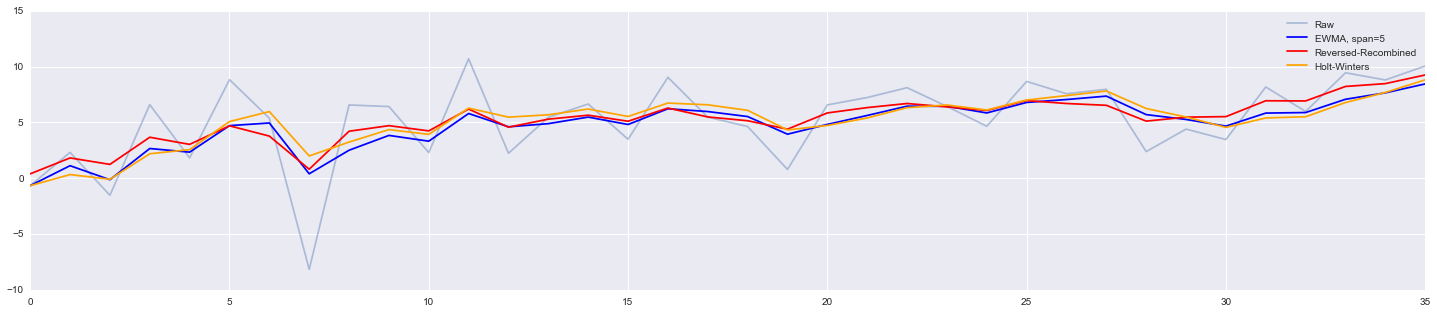

In [452]:
# make a hat function, and add noise
# x = np.linspace(0,1,100)
# x = np.hstack((x,x[::-1]))
# x += np.random.normal( loc=0, scale=0.1, size=200 )
plt.rcParams['figure.figsize'] = (25.0, 5.0)
x = iy1
plot(x, alpha=0.4, label='Raw' )

# take EWMA in both directions with a smaller span term
fwd = ewma( x, span=5 )          # take EWMA in fwd direction
bwd = ewma( x[::-1], span=5 )    # take EWMA in bwd direction
c = np.vstack(( fwd, bwd[::-1] )) # lump fwd and bwd together
c = np.mean( c, axis=0 )          # average  

# regular EWMA, with bias against trend
plot( ewma( x, span=5 ), 'b', label='EWMA, span=5' )

# "corrected" (?) EWMA
plot( c, 'r', label='Reversed-Recombined' )

#savefig( 'ewma_correction.png', fmt='png', dpi=100 )

def holt_winters_second_order_ewma(x, span, beta):
    N = x.size
    alpha = 2.0 / ( 1 + span )
    s = np.zeros(( N, ))
    b = np.zeros(( N, ))
    s[0] = x[0]
    for i in range( 1, N ):
        s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
        b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
    return s
 
# make a hat function, and add noise
# x = np.linspace(0,1,100)
# x = np.hstack((x,x[::-1]))
# x += np.random.normal( loc=0, scale=0.1, size=200 ) + 3.0
#plot( iy1, alpha=0.4, label='Raw' )
 
# holt winters second order ewma
plot( holt_winters_second_order_ewma(iy1, 5, 0.3), 'orange', label='Holt-Winters' )
 
#title('Holt-Winters' )
legend( loc=1 )
 
#savefig( 'holt_winters.png', fmt='png', dpi=100 )

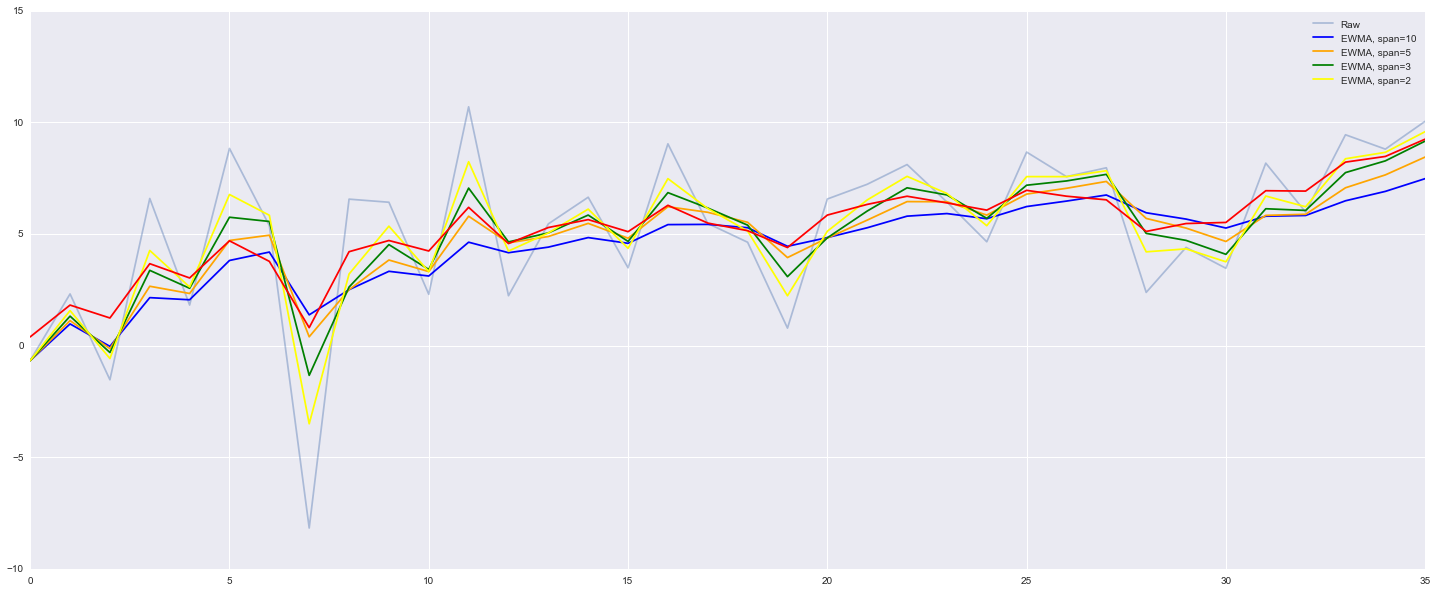

In [419]:
plt.rcParams['figure.figsize'] = (25.0, 10.0)
x = iy1
plot(x, alpha=0.4, label='Raw' )

# take EWMA in both directions with a smaller span term
fwd = ewma( x, span=5 )          # take EWMA in fwd direction
bwd = ewma( x[::-1], span=5 )    # take EWMA in bwd direction
c = np.vstack(( fwd, bwd[::-1] )) # lump fwd and bwd together
c = np.mean( c, axis=0 )          # average  

# regular EWMA, with bias against trend
plot( ewma( x, span=10 ), 'b', label='EWMA, span=10' )
plot( ewma( x, span=5 ), 'orange', label='EWMA, span=5' )
plot( ewma( x, span=3 ), 'green', label='EWMA, span=3' )
plot( ewma( x, span=2 ), 'yellow', label='EWMA, span=2' )
#plot( c, 'black', label='Reversed-Recombined2' )
legend( loc=1 )

# "corrected" (?) EWMA
plot( c, 'r', label='Reversed-Recombined' )

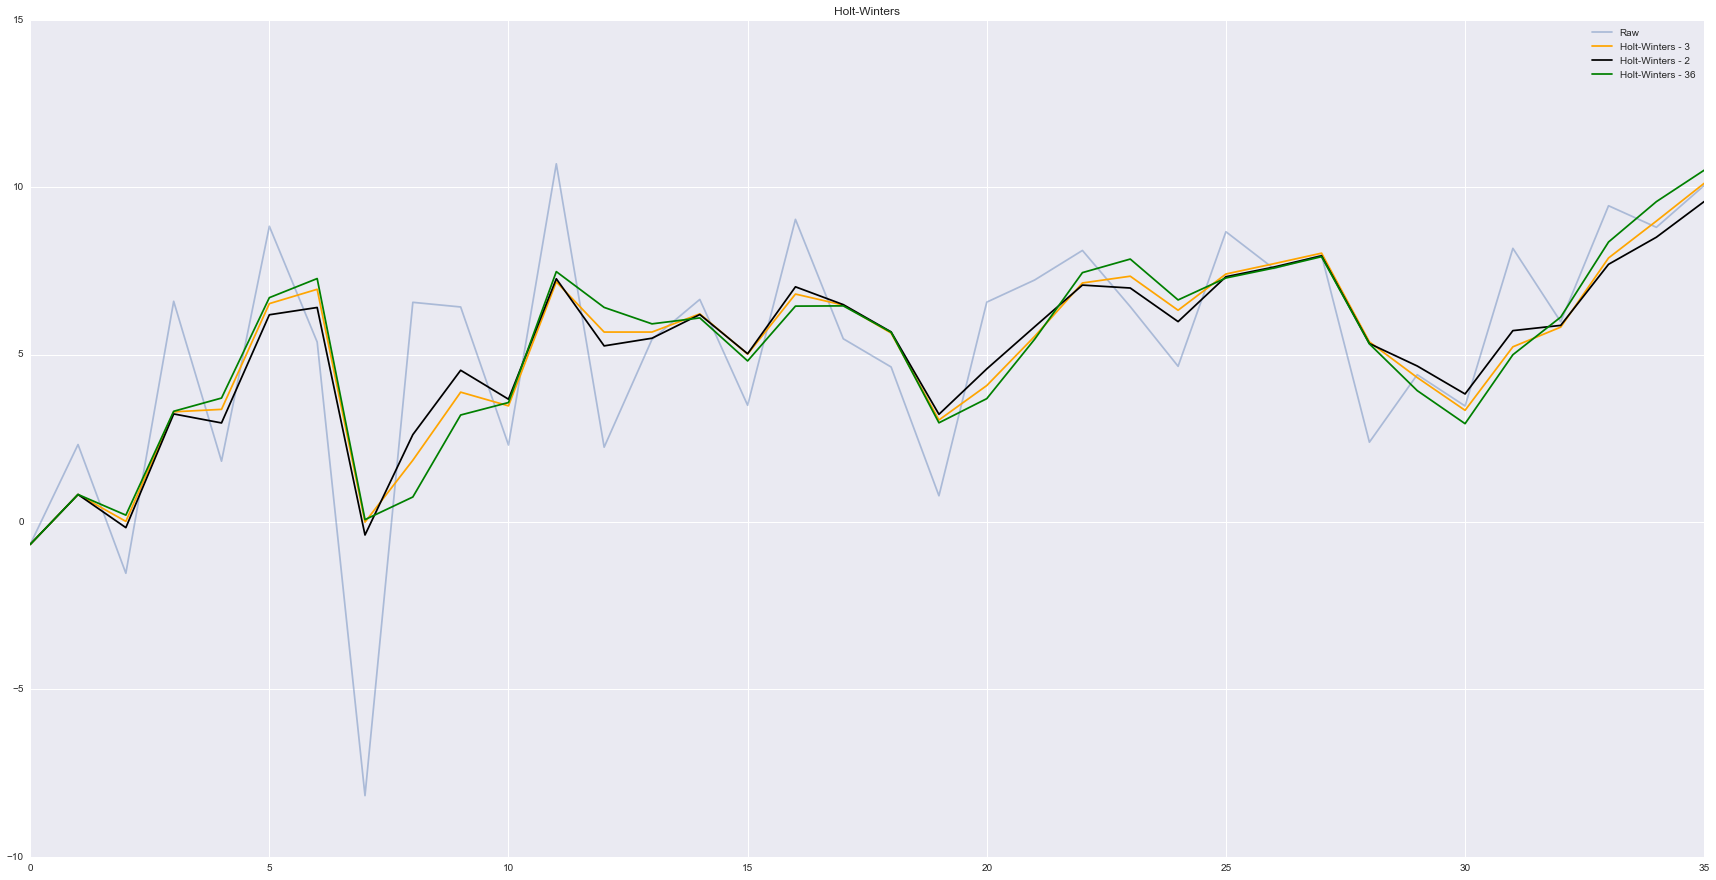

In [497]:
plt.rcParams['figure.figsize'] = (30.0, 15.0)
def holt_winters_second_order_ewma(x, span, beta):
    N = x.size
    alpha = 2.0 / ( 1 + span )
    s = np.zeros(( N, ))
    b = np.zeros(( N, ))
    s[0] = x[0]
    for i in range( 1, N ):
        s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
        b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
    return s
plot( iy1, alpha=0.4, label='Raw' )

# holt winters second order ewma
#plot( holt_winters_second_order_ewma(iy1, 5, 1), 'b', label='Holt-Winters - 10' )
#plot( holt_winters_second_order_ewma(iy1, 5, 0.25), 'red', label='Holt-Winters - 5' )
plot( holt_winters_second_order_ewma(iy1, 3, 0.5), 'orange', label='Holt-Winters - 3' )
plot( holt_winters_second_order_ewma(iy1, 3, 0.25), 'black', label='Holt-Winters - 2' )
plot( holt_winters_second_order_ewma(iy1, 3, .75), 'green', label='Holt-Winters - 36' )
title('Holt-Winters' )
legend( loc=0)
#savefig( 'holt_winters.png', fmt='png', dpi=100 )

In [479]:
q=holt_winters_second_order_ewma(iy1, 3, 0.25)

In [480]:
#iy1.shape = (7,5)
p=iy1

In [482]:
e=p-q
e

array([0.0, 1.4916949694999999, -1.3629837329374999, 3.3640925869609375,
       -1.1425586079599603, 2.6434342480745858, -1.0312358384174649,
       -7.7853433553613067, 3.9525233005869351, 1.8905221559876892,
       -1.3693210268103946, 3.4341671586418627, -3.0254464589622416,
       -0.036094754394014217, 0.45143358318935256, -1.5393804109176341,
       2.0148541513935765, -1.0196856138750148, -1.0475164652749331,
       -2.4323546638155258, 1.9944037823911183, 1.3964875476955516,
       1.0348010763858237, -0.55632374281726804, -1.3337052835666556,
       1.3440675610044828, -0.044674058835508568, 0.015779757598934907,
       -2.9462580213837106, -0.25963679470206902, -0.35931670802349069,
       2.4577477638187357, 0.10827032626250599, 1.7487440042015781,
       0.29620736864591635, 0.47920876278734603], dtype=object)

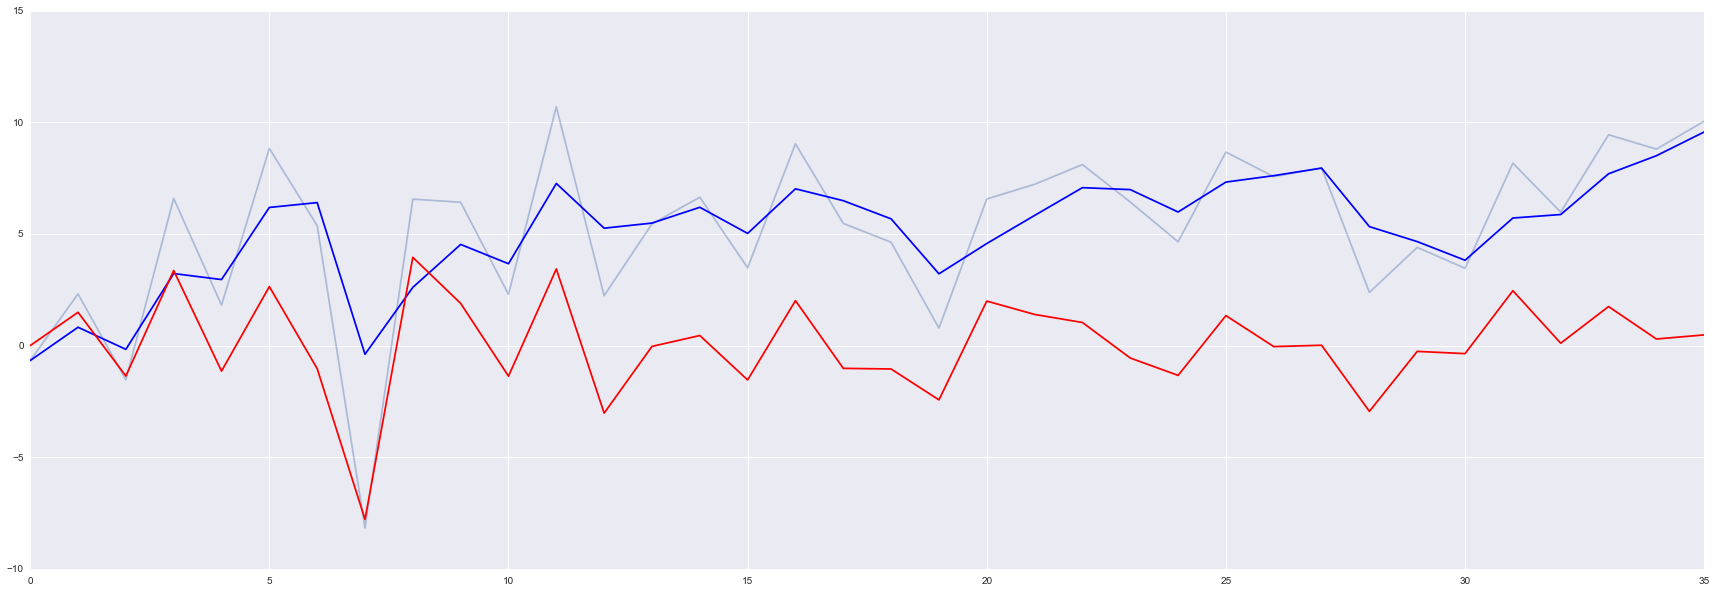

In [487]:
plt.rcParams['figure.figsize'] = (30.0, 10.0)
plot( iy1, alpha=0.4, label='Raw' )
plot(q,'blue')
plot(e,'red')
# holt winters second order ewma
#plot( holt_winters_second_order_ewma(iy1, 5, 1), 'b', label='Holt-Winters - 10' )
#plot( holt_winters_second_order_ewma(iy1, 5, 0.25), 'red', label='Holt-Winters - 5' )


In [332]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import Range1d

from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Statsmodel APIs
import statsmodels.api as sm

In [ ]:
def dataset():
    x = np.array([ -1, 0, 1,   2, 3, 5, 7, 9 ])
    y = np.array([ -1, 3, 2.5, 5, 4, 2, 5, 4 ])

    X = np.c_[x ** 5, x ** 4, x ** 3, x ** 2, x, np.ones(len(x))]

    res = sm.OLS(y, X).fit()

    ridge = Ridge(alpha = .2)
    ridge.fit(np.vander(x, 6), y)

    lasso = Lasso(alpha = 1)
    lasso.fit(np.vander(x, 6), y)

    p = figure(title = "Regularization")
    p.circle(x, y, size = 8, color = 'blue')

    xx = np.linspace(-1.25, 10, 100)

    p.line(xx, res.predict(np.vander(xx, 6)), color = 'red')
    p.line(xx, ridge.predict(np.vander(xx, 6)), color = 'green')
    p.line(xx, lasso.predict(np.vander(xx, 6)), color = 'cyan')

    # Ridge predict is better

    show(p)
dataset()

In [ ]:
#with the null values

In [27]:
indianr = india.loc[india2.index]

In [28]:
indianr = indianr[generate_year_list(1972, 2007)]

In [ ]:
np.random.seed(100)
rand_rows = np.random.choice(indianr.index.values, size=1240)

def plot_rows(data, ids=None, linestyle="-", legend=True):
    # get some colors for the lines
    bmap = pplt.brewer2mpl.get_map('Set3','Qualitative', 10, True)
    #colors = bmap.mpl_colors
    
    if not None == ids:
        get_rows = lambda: enumerate(ids)
    else:
        get_rows = lambda: enumerate(data.index.values)
    
    for i, r in get_rows():
        # get the time series values
        time_data = data.loc[r]

        # create an x axis to plot along
        just_years = [y[:4] for y in data.columns]
        X = pd.DatetimeIndex(just_years)

        # get time series info for labeling
        country, descrip = india[["Country Name", "Series Name"]].loc[r]

        # plot the series
        plt.plot(X, time_data, 
                 label="{} - {}".format(country, descrip), ls=linestyle)
        plt.scatter(X, time_data, alpha=0.8)

#     if legend:
#         plt.legend(loc=0)
    plt.title("Progress Towards Subset of MDGs")

plot_rows(indianr, ids=rand_rows)
plt.show()

In [29]:
indianr_pr = training_data.loc[submission_labels.index]

In [237]:
from pandas.tools.plotting import scatter_matrix


In [ ]:
np.corrcoef(indiar,indiar)

In [ ]:
np.corrcoef(indiar)